The Challenge - One challenge of modeling retail data is the need to make decisions based on limited history. Holidays and select major events come once a year, and so does the chance to see how strategic decisions impacted the bottom line. In addition, markdowns are known to affect sales – the challenge is to predict which departments will be affected and to what extent. 

You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

Within the Excel Sheet, there are 3 Tabs – Stores, Features and Sales 

Features

Contains additional data related to the store, department, and regional activity for the given dates.

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week


Sales

Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week


The Task

    Predict the department-wide sales for each store for the following year
    Model the effects of markdowns on holiday weeks
    Provide recommended actions based on the insights drawn, with prioritization placed on largest business impact


In [243]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [137]:
feat = pd.read_csv('feat.csv',  thousands=',')
sales = pd.read_csv('salsesdata.csv',  thousands=',')
stores = pd.read_csv('stores.csv',  thousands=',')

In [138]:
sales.head(5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,5/2/2010,24924.50,False
1,1,1,12/2/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,5/3/2010,21827.90,False


In [139]:
feat.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,5/2/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/2/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,5/3/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [140]:
stores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [141]:
safe = pd.merge(sales,feat, on = ['Store','Date','IsHoliday'], how='left')
cardata = pd.merge(safe, stores, on=['Store'], how='left')

In [142]:
safe.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,5/2/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,12/2/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,5/3/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [143]:
cardata.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [144]:
cardata=cardata.fillna(0)

In [145]:
cardata.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


In [146]:
print(cardata.shape)

(421570, 16)


In [147]:
cardata.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [148]:
cardata.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


In [149]:
#how much money a dealership will make during a holiday 

# add column IsHoliday 0 is False and 1 is True 

In [150]:
cardata.T

,0,1,2,3,4,5,6,7,8,9,...,421560,421561,421562,421563,421564,421565,421566,421567,421568,421569
Store,1,1,1,1,1,1,1,1,1,1,...,45,45,45,45,45,45,45,45,45,45
Dept,1,1,1,1,1,1,1,1,1,1,...,98,98,98,98,98,98,98,98,98,98
Date,5/2/2010,12/2/2010,19/02/2010,26/02/2010,5/3/2010,12/3/2010,19/03/2010,26/03/2010,2/4/2010,9/4/2010,...,24/08/2012,31/08/2012,7/9/2012,14/09/2012,21/09/2012,28/09/2012,5/10/2012,12/10/2012,19/10/2012,26/10/2012
Weekly_Sales,24924.5,46039.5,41595.6,19403.5,21827.9,21043.4,22136.6,26229.2,57258.4,42960.9,...,415.4,346.04,352.44,605.96,467.3,508.37,628.1,1061.02,760.01,1076.8
IsHoliday,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
Temperature,42.31,38.51,39.93,46.63,46.5,57.79,54.58,51.45,62.27,65.86,...,72.62,75.09,75.7,67.87,65.32,64.88,64.89,54.47,56.47,58.85
Fuel_Price,2.572,2.548,2.514,2.561,2.625,2.667,2.72,2.732,2.719,2.77,...,3.834,3.867,3.911,3.948,4.038,3.997,3.985,4,3.969,3.882
MarkDown1,0,0,0,0,0,0,0,0,0,0,...,7936.2,23641.3,11024.5,11408,8452.2,4556.61,5046.74,1956.28,2004.02,4018.91
MarkDown2,0,0,0,0,0,0,0,0,0,0,...,58.38,6,12.8,0,92.28,20.64,0,0,0,58.08
MarkDown3,0,0,0,0,0,0,0,0,0,0,...,22,92.93,52.63,4.3,63.24,1.5,18.82,7.89,3.18,100


In [151]:
cardata.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


In [152]:
cardata.dropna()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315
5,1,1,12/3/2010,21043.39,False,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,A,151315
6,1,1,19/03/2010,22136.64,False,54.58,2.720,0.00,0.00,0.00,0.00,0.00,211.215635,8.106,A,151315
7,1,1,26/03/2010,26229.21,False,51.45,2.732,0.00,0.00,0.00,0.00,0.00,211.018042,8.106,A,151315
8,1,1,2/4/2010,57258.43,False,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,A,151315
9,1,1,9/4/2010,42960.91,False,65.86,2.770,0.00,0.00,0.00,0.00,0.00,210.622857,7.808,A,151315


In [153]:
IsHolidayflag = []

In [154]:
cardata.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


In [155]:
cardatanew = cardata

In [156]:
cardatanew['holidayflag']  = cardatanew.apply(lambda row: row['IsHoliday'] + row['IsHoliday'], axis=1)

In [157]:
cardatanew.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,2
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0


In [268]:
cardatanew.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,1
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0


In [159]:
cardataok = cardatanew.replace(2,1)

In [269]:
cardataok.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,1
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0


In [161]:
cardatanew = cardataok

In [162]:
cardatanew.head(6)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
0,1,1,5/2/2010,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,0
1,1,1,12/2/2010,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,1
2,1,1,19/02/2010,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,0
3,1,1,26/02/2010,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,0
4,1,1,5/3/2010,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,0
5,1,1,12/3/2010,21043.39,False,57.79,2.667,0.0,0.0,0.0,0.0,0.0,211.380643,8.106,A,151315,0


In [163]:
cardata.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,holidayflag
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,0.140717
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,0.511501
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,0.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,0.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,0.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,0.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,2.000000


In [164]:
cardatanew.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2       False
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
holidayflag     False
dtype: bool

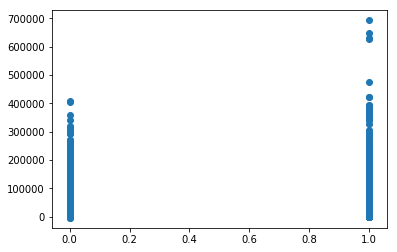

In [165]:
x = cardatanew['Weekly_Sales']
y = cardatanew['holidayflag']
plt.scatter(y,x)
plt.show()

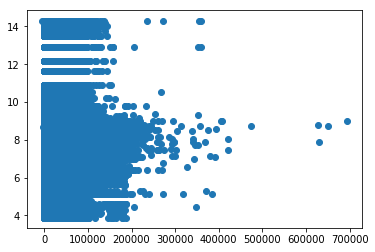

In [166]:
x = cardatanew['Weekly_Sales']
y = cardatanew['Unemployment']
plt.scatter(x,y)
plt.show()

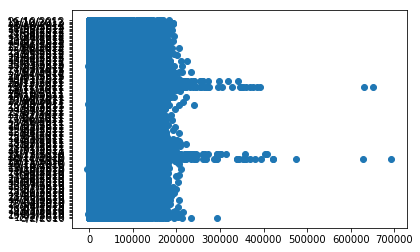

In [167]:
x = cardatanew['Weekly_Sales']
y = cardatanew['Date']
plt.scatter(x,y)
plt.show()

In [168]:
carnew = cardatanew.groupby('Date').max()

In [169]:
carnew.head(10)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
Date,,,,,,,,,,,,,,,,
1/10/2010,45,99,174219.51,False,91.45,3.001,0.00,0.00,0.00,0.00,0.00,215.214134,14.313,C,219622,0
1/4/2011,45,99,175473.67,False,71.41,3.811,0.00,0.00,0.00,0.00,0.00,218.445164,13.736,C,219622,0
1/6/2012,45,99,165598.92,False,83.57,4.277,16432.28,123.00,441.83,4069.79,9316.50,225.494608,11.627,C,219622,0
1/7/2011,45,98,175468.71,False,98.43,3.916,0.00,0.00,0.00,0.00,0.00,218.779641,13.503,C,219622,0
10/12/2010,45,99,221013.44,False,60.72,3.255,0.00,0.00,0.00,0.00,0.00,214.998138,14.313,C,219622,0
10/2/2012,45,99,233140.32,True,59.94,3.826,36778.65,13498.72,285.82,29483.81,10618.93,223.995301,12.187,C,219622,1
10/6/2011,45,99,190737.26,False,87.02,4.025,0.00,0.00,0.00,0.00,0.00,218.636575,13.736,C,219622,0
10/8/2012,45,99,194032.48,False,100.07,3.863,37938.11,798.52,178.81,14696.25,14827.71,225.717009,10.926,C,219622,0
10/9/2010,45,98,205314.67,True,91.77,3.044,0.00,0.00,0.00,0.00,0.00,215.035932,14.180,C,219622,1


In [170]:
carnew.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,holidayflag
count,143.0,143.000000,143.000000,143.000000,143.000000,143.000000,143.00000,143.000000,143.000000,143.000000,143.000000,143.000000,143.0,143.000000
mean,45.0,98.657343,197629.053497,77.918252,3.651259,7004.395315,2436.31000,1380.150490,3419.424336,8110.452937,219.626689,13.116483,219622.0,0.069930
std,0.0,0.476266,64287.891821,14.442055,0.456502,12746.759030,10670.83963,12043.538688,8293.481594,17257.843785,4.440007,1.208114,0.0,0.255926
min,45.0,98.000000,144127.680000,49.260000,2.910000,0.000000,0.00000,0.000000,0.000000,0.000000,213.846982,10.199000,219622.0,0.000000
25%,45.0,98.000000,174548.295000,64.570000,3.129000,0.000000,0.00000,0.000000,0.000000,0.000000,215.098948,12.187000,219622.0,0.000000
50%,45.0,99.000000,184591.990000,77.920000,3.805000,0.000000,0.00000,0.000000,0.000000,0.000000,219.076855,13.736000,219622.0,0.000000
75%,45.0,99.000000,201706.135000,91.470000,4.017000,11366.440000,395.50000,132.480000,3867.835000,11850.870000,224.266502,14.099000,219622.0,0.000000
max,45.0,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.54000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.0,1.000000


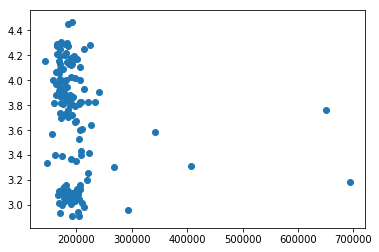

In [171]:
x = carnew['Weekly_Sales']
y = carnew['Fuel_Price']
plt.scatter(x,y)
plt.show()

In [172]:
carnew.isnull().any()

Store           False
Dept            False
Weekly_Sales    False
IsHoliday       False
Temperature     False
Fuel_Price      False
MarkDown1       False
MarkDown2       False
MarkDown3       False
MarkDown4       False
MarkDown5       False
CPI             False
Unemployment    False
Type            False
Size            False
holidayflag     False
dtype: bool

C:\Users\Naeemah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


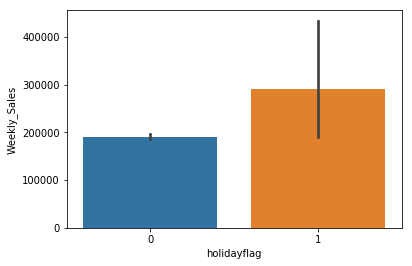

In [173]:
x = carnew['holidayflag']
y = carnew['Weekly_Sales']
sns.barplot(x, y);

C:\Users\Naeemah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


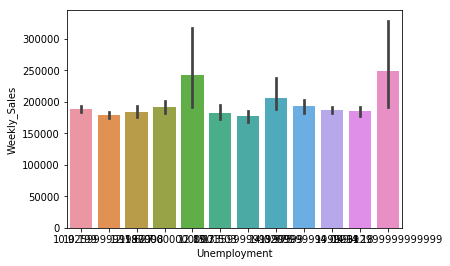

In [174]:
x = carnew['Unemployment']
y = carnew['Weekly_Sales']
sns.barplot(x, y);

C:\Users\Naeemah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


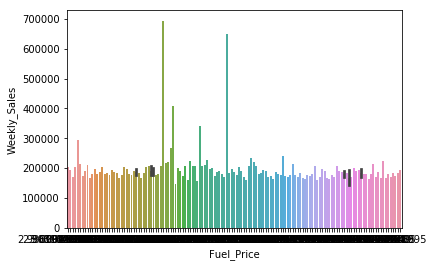

In [175]:
x = carnew['Fuel_Price']
y = carnew['Weekly_Sales']
sns.barplot(x, y);

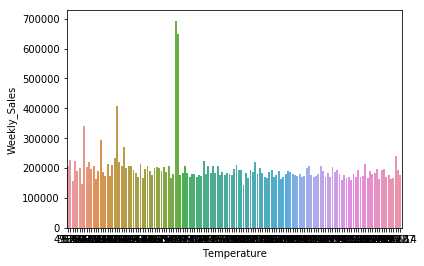

In [176]:
x = carnew['Temperature']
y = carnew['Weekly_Sales']
sns.barplot(x, y);

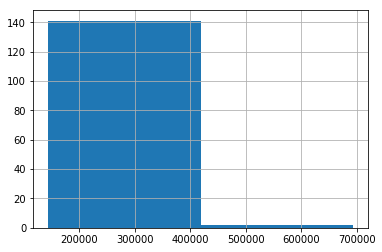

In [177]:
carnew['Weekly_Sales'].hist(bins=2)

In [178]:
pd.DataFrame(carnew, index =[0])

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,holidayflag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
corr_matrix = carnew.corr()
corr_matrix["Weekly_Sales"].sort_values(ascending=False)

Weekly_Sales    1.000000
MarkDown3       0.581009
holidayflag     0.402043
IsHoliday       0.402043
Unemployment    0.104602
Dept            0.009947
MarkDown4      -0.034444
MarkDown2      -0.038703
MarkDown5      -0.042303
MarkDown1      -0.048396
CPI            -0.083220
Fuel_Price     -0.134121
Temperature    -0.221514
Store                NaN
Size                 NaN
Name: Weekly_Sales, dtype: float64

In [223]:
carnew.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'holidayflag'],
      dtype='object')

In [228]:
len(carnew['Weekly_Sales'].value_counts())

143

In [236]:
#P(weeklysales and holiday) = P(holiday) * P(weeklysales / holiday)
#P(target and predictor) = P(predictor) * P(target / predictor)

How to build a basic model using Naive Bayes in Python?

Again, scikit learn (python library) will help here to build a Naive Bayes model in Python. There are three types of Naive Bayes model under scikit learn library:

    Gaussian: It is used in classification and it assumes that features follow a normal distribution.

    Multinomial: It is used for discrete counts. For example, let’s say,  we have a text classification problem. Here we can consider bernoulli trials which is one step further and instead of “word occurring in the document”, we have “count how often word occurs in the document”, you can think of it as “number of times outcome number x_i is observed over the n trials”.

    Bernoulli: The binomial model is useful if your feature vectors are binary (i.e. zeros and ones). One application would be text classification with ‘bag of words’ model where the 1s & 0s are “word occurs in the document” and “word does not occur in the document” respectively.


In this example we use the Python library SKLearn to create a model and make predictions. SKLearn library requires the features to be numerical arrays. So we will need to convert the categorical information in our data into numbers.

There are multiple ways of doing this, we will keep is simple and use a LabelEncoder for this example.

A LabelEncoder converts a categorical data into a number ranging from 0 to n-1, where n is the number of classes in the variable.



In [260]:
number = LabelEncoder()
carnew['Weekly_Sales'] = number.fit_transform(carnew['Weekly_Sales'])
#carnew['Fuel_Price'] = number.fit_transform(carnew['Fuel_Price'])
#carnew['Unemployment'] = number.fit_transform(carnew['Unemployment'])
#carnew['Temperature'] = number.fit_transform(carnew['Temperature'])
carnew['holidayflag'] = number.fit_transform(carnew['holidayflag'])

In [270]:
#features = ["Weekly_Sales", "Fuel_Price", "Unemployment", "Temperature"]
#target = "holidayflag"

features = ["Weekly_Sales"]
target = "holidayflag"

In [271]:
features_train, features_test, target_train, target_test = train_test_split(carnew[features],carnew[target],test_size = 0.33,random_state = 54)

In [272]:
model = GaussianNB()

In [273]:
model.fit(features_train, target_train)

GaussianNB(priors=None)

In [274]:
pred = model.predict(features_test)
accuracy = accuracy_score(target_test, pred)

In [275]:
print(accuracy)

0.9166666666666666


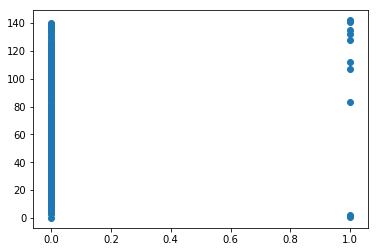

In [284]:
plt.scatter(carnew.holidayflag,carnew.Weekly_Sales)

People will buy a car on a non-holiday, then a holiday 